In [1]:
import pandas as pd 
import numpy as np 
import networkx as nx 
import json 
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime
import tqdm
import pickle

In [2]:
provinceTags = ['PI','PO','LI','FI','AR','PT','GR','MS','SI','LU']

In [3]:
G = nx.read_graphml('../data/clean/byuser.graphml',node_type=int)
print(len(G),len(G.edges))

9107 111741


In [4]:
for node in list(G.nodes)[:3]: print(node,G.nodes[node])
for node in list(G.edges)[:3]: print(node,G.edges[node])

0 {'province': 'PI', 'covidMeasure': 0, 'latitude': 43.85180773789867, 'longitude': 10.506207}
15775 {'province': 'LU', 'covidMeasure': 0, 'latitude': 43.85135, 'longitude': 10.506207}
1979 {'province': 'FI', 'covidMeasure': 0, 'latitude': 43.76973, 'longitude': 11.26562}
(0, 15775, 0) {'start': 414, 'end': 414, 'user': 'RobertaC2372', 'days': 0, 'geodistance': 0.0004577378986709846}
(0, 15775, 1) {'start': 414, 'end': 414, 'user': 'ClaudioC138', 'days': 0, 'geodistance': 0.0004577378986709846}
(0, 15775, 2) {'start': 414, 'end': 414, 'user': 'juan pablo A 116887066', 'days': 0, 'geodistance': 0.0004577378986709846}


In [6]:
ts = pd.read_csv('../data/clean/covidars.csv', index_col=0)
ts.head()


,PI-positivi,PI-deceduti,PO-positivi,PO-deceduti,LI-positivi,LI-deceduti,FI-positivi,FI-deceduti,AR-positivi,AR-deceduti,PT-positivi,PT-deceduti,GR-positivi,GR-deceduti,MS-positivi,MS-deceduti,SI-positivi,SI-deceduti,LU-positivi,LU-deceduti
index,,,,,,,,,,,,,,,,,,,,
2020-02-14,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2020-02-15,0,0.0,0,0.0,0,0.0,1,0.0,0,0.0,1,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2020-02-16,0,0.0,0,0.0,0,0.0,2,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2020-02-17,0,0.0,0,0.0,0,0.0,1,0.0,0,0.0,1,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2020-02-18,0,0.0,0,0.0,0,0.0,7,0.0,0,0.0,1,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [5]:
df = pd.read_csv('../data/raw/geotuscany.csv', index_col=0)
df.head()

,position,name,city,menu,link,score,N_reviews,price,Name,Province,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,lucca,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,551,Acino Bianco,Marina di Massa,False,/Restaurant_Review-g194814-d12843022-Reviews-A...,4.5,92,2.5,Acino Bianco,massacarrara,...,44.004616,10.115488,Italian,Dinner,"Vegetarian Friendly, Gluten Free Options",yEU_https://maps.google.com/maps?saddr=&daddr=...,lucca,/Restaurant_Review-g194814-d12843022-Reviews-A...,0,NaN
2,308,El Artista Ristorante Argentino,Massa,False,/Restaurant_Review-g660766-d17543924-Reviews-E...,4.5,78,2.5,El Artista Ristorante Argentino,massacarrara,...,44.041000,10.124396,"Barbecue, Argentinean, Steakhouse","Dinner, Lunch",NaN,U0P_https://maps.google.com/maps?saddr=&daddr=...,lucca,/Restaurant_Review-g660766-d17543924-Reviews-E...,0,NaN
3,1285,La Locanda di Bivigliano,Bivigliano,False,/Restaurant_Review-g1957776-d13948598-Reviews-...,NaN,28,NaN,La Locanda di Bivigliano,florence,...,43.893859,11.322421,"Italian, Mediterranean, Barbecue, Tuscan, Cent...",NaN,Vegetarian Friendly,rg1_https://maps.google.com/maps?saddr=&daddr=...,prato,/Restaurant_Review-g1957776-d13948598-Reviews-...,0,NaN
4,1499,Beach Bar @PuntAla,Punta Ala,False,/Restaurant_Review-g194871-d19315573-Reviews-B...,2.5,2,1.0,Beach Bar @PuntAla,grosseto,...,42.841410,10.775602,"Italian, Mediterranean","Lunch, Brunch, Drinks",NaN,32Q_https://maps.google.com/maps?saddr=&daddr=...,grosseto,/Restaurant_Review-g194871-d19315573-Reviews-B...,1,NaN


In [9]:
df.isnull().sum()

position                0
name                    0
city                    2
menu                    0
link                    0
score                 545
N_reviews               0
price                3041
Name                    0
Province                0
City                    0
claimed                 0
covidMeasure            0
travellersChoice        0
latitude                4
longitude               4
cuisines             1411
meals                6664
specialDiets         8762
positionlink            4
province                0
Link                 1839
provinceOK              0
longitud§e          15064
dtype: int64

In [7]:
print(nx.dijkstra_path(G,3,4))
print(nx.dijkstra_path(G,3,4,weight = 'geodistance'))
print(nx.dijkstra_path(G,3,4,weight = 'days'))

[3, 1450, 618, 1385, 413, 12970, 4]
[3, 2429, 2016, 446, 2364, 2529, 2238, 2230, 1739, 13764, 13861, 13820, 13835, 12970, 4]
[3, 1450, 2285, 1832, 999, 12970, 4]


In [8]:
o = nx.dijkstra_predecessor_and_distance(G,3, weight="days")

# Time Respecting Path 

In [6]:
from heapq import heappop, heappush

In [7]:
def single_source_time_respecting_paths(g,source,weights=None):
    
    def mintime(g, u, v, date = 0):
        k = 0
        mink = 0
        minimal = float('inf') 
        while True: 
            try :
                end = g.edges[(u,v,k)]['end']
                start = g.edges[(u,v,k)]['start']
            except: break
            if start >= date and end < minimal: 
                minimal = end 
                mink = k 
                
            k += 1
    
        return minimal, mink

    
    dist = dict()
    Q = list()
    
    heappush(Q, source)
 
    # set initial distance from the source to `v` as INFINITY
    dist = {node : float('inf') for node in g.nodes}
    dist[source] = 0
    
    time = {node : 0 for node in g.nodes}
    time[source] = 0
    
    prev = {node : -1 for node in g.nodes}
    index = {source: 0}
    done = {node : False for node in g.nodes}
    done[source] = True
    
    
    
    while Q:
 
        u = heappop(Q)      # Remove and return the best vertex
        
 
        # do for each neighbor `v` of `u`
        for v in g.neighbors(u):
            
            firstvisit, firstk = mintime(g,u,v, date = time[u])
            
            # Relaxation step 
            if firstvisit == float('inf'): continue
                
            if weights ==None :weight = 1
            else: weight = g.edges[(u,v,firstk)][weights]
            
            if not done[v] and (dist[u] + weight) < dist[v]:
                
                dist[v] = dist[u] + weight
                prev[v] = u
                time[v] = firstvisit
                index[v] = firstk
                heappush(Q, v)
 
        # mark vertex `u` as done so it will not get picked up again
        done[u] = True
        
        
    def get_route(prev, time, index, i, route):
        if i >= 0:
            get_route(prev, time, index, prev[i], route)
            route.append((i,index[i],time[i]))    
        
    route = list()
    routes = dict()
    for i in g.nodes:
        if i != source and dist[i] <float('inf'):
            get_route(prev, time, index, i, route)
            routes[(source,i)] = route.copy()
            #print(f"Path ({source} —> {i}): Minimum cost = {dist[i]}, Route = {route}")
            route.clear()
            
    return routes

In [12]:
r = single_source_time_respecting_paths(G,0)

In [8]:
def all_time_respecting_paths(g,weights=None):
    all_routes = dict()
    for node in tqdm.tqdm(g.nodes):
        all_routes.update(single_source_time_respecting_paths(g,node,weights))
    
    return all_routes


#### SHORTEST PATHS

In [15]:
routes = all_time_respecting_paths(G)

100%|████████████████████████████████████████████████████████████████████████████| 9107/9107 [1:27:22<00:00,  1.74it/s]


In [16]:

with open('../data/clean/allpaths.PICKLE','wb') as f:
    pickle.dump(routes,f)
    
        

In [117]:

with open('../data/clean/allpaths.PICKLE','rb') as f:
    routes = pickle.load(f)
    
        

In [81]:
longestRoutes = list()
maxLength = 0
fastestRoutes = list()
maxVelocity = 0

for i, route in tqdm.tqdm(routes.items()) :
    
    length = len(route)
    
    j,k,_ = route[1]
    
    start = G.edges[(i[0],j,k)]['start']
    end = route[-1][-1]
    timeElapsed = end-start+1
    velocity = length / timeElapsed
    
    if velocity > maxVelocity:
        maxVelocity = velocity 
        fastestRoutes = [i]
        
    elif velocity == maxVelocity:
        fastestRoutes.append(i)
    
    
    if length > maxLength:
        maxLength = length 
        longestRoutes = [i]
        
    elif length == maxLength:
        longestRoutes.append(i)
    
    

100%|██████████████████████████████████████████████████████████████████| 22791375/22791375 [02:47<00:00, 136285.75it/s]


In [87]:
print(maxLength, longestRoutes,'\n',maxVelocity,fastestRoutes)

45 [(921, 6896), (4189, 6896), (3807, 6896), (4411, 6896)] 
 6.0 [(141, 14695), (10762, 10141), (10442, 13645)]


In [88]:
for route in  longestRoutes: 
    for i,j,k in routes[route]: print(df.loc[i,'name'],k)
    print()

Pizzeria Il Corso
DA Gastone
Il Ristoro Da Lisa
La Vecchia Hosteria
Oltre il Gusto
Il Beccofino
Zero Distanze
La Terrazza Bistrot
Skipper Beach Club
MUN sushi lab
Mister Pizza
Osteria Vecchio Cancello
Mattacena
LA GROTTA TOSCANA (EX LA REPUBBLICA)
Belfiore
Godo
Caffe Salvemini
Caffetteria Piansa
Cafe Badia
Bar Beyfin - by Gianno
D Osteria Moderna
Panineria I 5 Sensi
Friggio Pontassieve
Otto bistro & pizza
I Francescani
Arnolds fiaschetteria
Deliburger Firenze Sud
Bistro Gran Caffe Pinseria
La Bottega Del Caffe
Trattoria I' Pepolino
Hibiki-an
Fast Mood
L'originale Fornetto di Rufina
Runner Pizza
Yin Xiang
La Bottega Di Gabri
Pasticceria Maioli
Bar Sport
Mozzarella e Basilico
Pizza Taxi
Royal Bar
Caffe Giannotti
Ristorante Giapponese Kikawa
Giglio Pizza
Bar Tre Enne

Ristorante Abramo
Ristorante Villa Brignole
Pescetarian
Pizzeria O'Vesuvio
Oscar
Il Peperoncino
Il Canguro
Osteria Il Sigillo
Da'vi'
La Tortuga
Il Ritrovino
Merenderia Riserva Naturale
Bagno Laura - Bistrot di Mare e Beach B

In [92]:
for route in  fastestRoutes: 
    for i,j,k in routes[route]: print(df.loc[i,'name'],k)
        
    print()

Il Cantuccio 0
Osteria La Torre di Populonia 160
La Baracchina 160
Osteria del Faro 160
Il Cedrino 160
Osteria del Bastian Contrario 160

Umami 0
La Lucciola 182
Ristorante Bar Maitu 182
Osteria dei Quattro Rioni 182
Kontiki 182
La Rustica 182

Ristorante dell'Azienda Agricola Sapereta 0
Ristorante Bar Maitu 182
Osteria dei Quattro Rioni 182
Osteria Pepenero 182
Gabbiano 3.0 182
Da Grazia 182



In [91]:
 routes[(1886, 11883)]

[(1886, 0, 0), (11883, 0, 244)]

In [21]:
float('inf') > float('inf')


False

#### SHORTEST GEODISTANCE PATHS

In [9]:
def geoDistance(df,u,v):
    
    xi, yi = df.loc[u,['longitude','latitude']]
    xj, yj = df.loc[v,['longitude','latitude']]
    return ((xj-xi)**2 + (yj-yi)**2)**0.5

In [10]:
def geolen(g,path):
    dist = 0 
    for i,u in enumerate(path):
        if u != path[-1]:
            v,k,t = path[i+1]
            dist += g.edges[(u[0],v,k)]['geodistance']
        
    return dist


In [9]:
georoutes = all_time_respecting_paths(G,weights='geodistance')

100%|██████████████████████████████████████████████████████████████████████████████| 9107/9107 [46:24<00:00,  3.27it/s]


In [10]:

with open('../data/clean/allpathsGeo.PICKLE','wb') as f:
    pickle.dump(georoutes,f)
    

In [11]:
import pickle
with open('../data/clean/allpathsGeo.PICKLE','rb') as f:
    routes = pickle.load(f)
    
        

In [18]:

longestRoutes = list()
maxLength = 0
fastestRoutes = list()
maxVelocity = 0

shortestRoutes = list()
maxShort = 0

for i, route in tqdm.tqdm(routes.items()) :
    
    length = geolen(G,route)
    
    j,k,_ = route[1]
 
    start = G.edges[(i[0],j,k)]['start']
    end = route[-1][-1]
    timeElapsed = end-start+1
    velocity = length / timeElapsed
    
    if velocity > maxVelocity:
        maxVelocity = velocity 
        fastestRoutes = [i]
        
    elif velocity == maxVelocity:
        fastestRoutes.append(i)
    
    
    if length > maxLength:
        maxLength = length 
        longestRoutes = [i]
        
    elif length == maxLength:
        longestRoutes.append(i)
        
  

100%|███████████████████████████████████████████████████████████████████| 22333895/22333895 [06:04<00:00, 61355.57it/s]


In [13]:

longestRoutes = list()
maxLength = 0
fastestRoutes = list()
maxVelocity = 0

shortestRoutes = list()
maxShort = 0

for i, route in tqdm.tqdm(routes.items()) :
    
    length = len(route)
    
    j,k,_ = route[1]
    distance = geoDistance(df,route[0][0],route[-1][0])
    short = distance / length
    
    start = G.edges[(i[0],j,k)]['start']
    end = route[-1][-1]
    timeElapsed = end-start+1
    velocity = length / timeElapsed
    
    if velocity > maxVelocity:
        maxVelocity = velocity 
        fastestRoutes = [i]
        
    elif velocity == maxVelocity:
        fastestRoutes.append(i)
    
    
    if length > maxLength:
        maxLength = length 
        longestRoutes = [i]
        
    elif length == maxLength:
        longestRoutes.append(i)
        
        
    if short > maxShort:
        maxShort = short
        shortestRoutes = [i]
        
    elif short == maxShort:
        shortestRoutes.append(i)
    

  0%|▎                                                                    | 85803/22333895 [00:51<3:43:38, 1658.04it/s]


KeyboardInterrupt: 

In [19]:
print(maxLength, longestRoutes,'\n',maxVelocity,fastestRoutes)

14.528237889341103 [(9019, 13925)] 
 3.828350581472482 [(11982, 11170)]


In [28]:
provincesCount = {p : 0 for p in provinceTags}
for route in  longestRoutes: 
    print(geolen(G,routes[route]),len(routes[route]))
    for i,j,k in routes[route]: 
        print(df.loc[i,'name'],k)
        provincesCount[G.nodes[i]['province']] +=1 
    print()

14.528237889341103 34
Ristorante Pizzeria Narnali 0
Osteria Mulinette 188
Quarantuno 200
Sette di Vino 208
La Cantina 208
Ristorante Degli Archi 208
Perseus 211
Ristorante Riso & Brace 219
Ciborgo 220
Il Galeone 221
Casa Masi 223
Trattoria Il Calesse 224
Enopizza & Risto 226
Ristorante Il Tiramestoli 230
Osteria di Casa Chianti 237
Mezzadria 238
Pesce e Pasta Monsummano Terme 245
Spizzometro 247
Spizzettando 248
Ristorante Greco Makedonia 253
Il Garibaldi Innamorato 254
Pizzeria Da Tonino 255
Move On 257
Pizzeria Le Simpatiche Canaglie 261
Circolo Arci Corniola 262
Pane e Salame 263
Acqua e Rame 264
Il Tegolo 265
Nagoya Empoli 267
Oasi al Lago 268
RitroVino 269
Trattoria Boves 284
Agriturismo bio-Ristorante La Degusteria 350
Trattoria da Marco Il Crusco 356



In [26]:
provincesCount

{'PI': 2,
 'PO': 2,
 'LI': 7,
 'FI': 16,
 'AR': 0,
 'PT': 2,
 'GR': 0,
 'MS': 0,
 'SI': 2,
 'LU': 3}

In [91]:
dedges = []
path = routes[(9019, 13925)]
for i,u in enumerate( path ):
     if u != path[-1]:
        v,k,t = path[i+1]
        dedges.append((u[0],v,k))

In [49]:
diameter = G.edge_subgraph(dedges).copy()

In [50]:
pos = {node : (diameter.nodes[node]['longitude'], diameter.nodes[node]['latitude']) for node in diameter.nodes}
pos

{1282: (10.944486, 43.72259),
 5891: (10.900363, 43.704582),
 14728: (10.230277, 43.957848),
 3849: (11.679167, 43.076885),
 2574: (10.989851, 43.706444),
 3215: (11.263715, 43.78412),
 8080: (10.683192, 43.69903515432098),
 10897: (10.526842, 42.923016),
 3477: (10.956239, 43.722527),
 2202: (10.94433, 43.720627),
 4122: (11.782937, 43.094757),
 10782: (10.366932, 43.461666),
 2464: (10.936058, 43.720093),
 2979: (10.800191, 43.858303),
 10279: (10.44594, 43.39816),
 3119: (10.991976, 43.83752),
 10418: (10.472847, 43.4071),
 1972: (11.109749, 43.581474),
 10036: (10.527006, 42.922726),
 6455: (10.864517, 43.750908),
 9019: (11.067916, 43.89484),
 8637: (10.403635, 43.713852),
 15678: (10.305469, 43.98832),
 10557: (10.683007, 42.952877),
 2633: (11.31553, 43.584248),
 3277: (11.255009, 43.772877),
 3157: (10.938245, 43.699787),
 10840: (10.4428, 43.39877),
 8931: (11.098162, 43.881092),
 1380: (10.950417, 43.71677),
 2276: (10.879033, 43.58235),
 13925: (10.246405, 43.86249),
 366: (

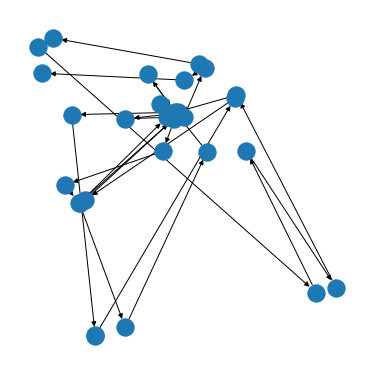

In [52]:
plt.figure(figsize = (5,5))
nx.draw(diameter,pos)

In [54]:
provincesCount = {p : 0 for p in provinceTags}
for route in  fastestRoutes: 
    print(geolen(G,routes[route]),len(routes[route]))
    for i,j,k in routes[route]: 
        print(df.loc[i,'name'],k)
        provincesCount[G.nodes[i]['province']] +=1 
    print()

3.828350581472482 5
Cassia Vetus 0
Raviolo e Raviolo 183
Ristorante Casa Puccini 183
Osteria Passaparola Nell'antico Frantoio 183
Ozium 183



In [56]:
provincesCount

{'PI': 1,
 'PO': 0,
 'LI': 0,
 'FI': 1,
 'AR': 1,
 'PT': 0,
 'GR': 1,
 'MS': 0,
 'SI': 0,
 'LU': 1}

In [92]:
fedges = []
path = routes[(11982, 11170)]
for i,u in enumerate( path ):
     if u != path[-1]:
        v,k,t = path[i+1]
        fedges.append((u[0],v,k))

In [93]:
edges = dedges+fedges
len(edges)

37

In [95]:
diameter = G.edge_subgraph(edges).copy()

In [94]:
pos = {node : (diameter.nodes[node]['longitude'], diameter.nodes[node]['latitude']) for node in diameter.nodes}
pos

{1282: (10.944486, 43.72259),
 5891: (10.900363, 43.704582),
 14728: (10.230277, 43.957848),
 3849: (11.679167, 43.076885),
 2574: (10.989851, 43.706444),
 3215: (11.263715, 43.78412),
 8080: (10.683192, 43.69903515432098),
 10897: (10.526842, 42.923016),
 3477: (10.956239, 43.722527),
 2202: (10.94433, 43.720627),
 4122: (11.782937, 43.094757),
 10782: (10.366932, 43.461666),
 2464: (10.936058, 43.720093),
 11170: (10.631944, 43.3148162200457),
 2979: (10.800191, 43.858303),
 14500: (10.50138, 43.843323),
 10279: (10.44594, 43.39816),
 3119: (10.991976, 43.83752),
 10418: (10.472847, 43.4071),
 1972: (11.109749, 43.581474),
 10036: (10.527006, 42.922726),
 6455: (10.864517, 43.750908),
 9019: (11.067916, 43.89484),
 8637: (10.403635, 43.713852),
 15678: (10.305469, 43.98832),
 10557: (10.683007, 42.952877),
 2633: (11.31553, 43.584248),
 3277: (11.255009, 43.772877),
 11982: (11.584239, 43.55028),
 3157: (10.938245, 43.699787),
 10840: (10.4428, 43.39877),
 8931: (11.098162, 43.881092

In [96]:
fedges

[(11982, 2165, 0), (2165, 14500, 0), (14500, 13668, 0), (13668, 11170, 0)]

In [99]:
colormap = []
for node in diameter.nodes:
    if node in [i[0] for i in fedges] or node in [i[1] for i in fedges] :
        colormap.append('red')
    else : colormap.append('blue')

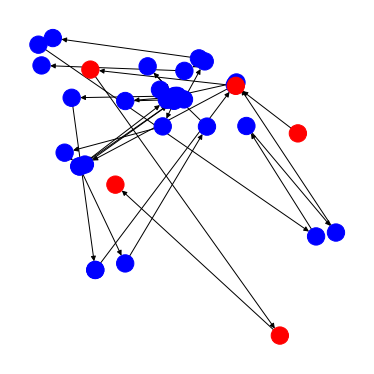

In [100]:
plt.figure(figsize = (5,5))
nx.draw(diameter,pos, node_color = colormap)

#### FASTEST PATHS

In [11]:
routes = all_time_respecting_paths(G,weights='days')

100%|██████████████████████████████████████████████████████████████████████████████| 9107/9107 [42:41<00:00,  3.56it/s]


In [ ]:

with open('../data/clean/allpathsDays.PICKLE','wb') as f:
    pickle.dump(routes,f)
    

In [13]:

with open('../data/clean/allpathsDays.PICKLE','rb') as f:
    routes = pickle.load(f)

In [15]:
def daylen(G,path):
    endDate = path[-1][2]
    startDate = G.edges[(path[0][0],path[1][0],path[1][1])]['start']
    
    return endDate - startDate + 1

In [22]:

longestRoutes = list()
maxLength = 0
fastestRoutes = list()
maxVelocity = 0

maxDuration = 0
slowestRoutes = []

for i, route in tqdm.tqdm(routes.items()) :
    
    length = len(route)
    
    j,k,_ = route[1]
    
    start = G.edges[(i[0],j,k)]['start']
    end = route[-1][-1]
    timeElapsed = end-start+1
    velocity = length / timeElapsed
    
    if velocity > maxVelocity:
        maxVelocity = velocity 
        fastestRoutes = [i]
        
    elif velocity == maxVelocity:
        fastestRoutes.append(i)
    
    
    if length > maxLength:
        maxLength = length 
        longestRoutes = [i]
        
    elif length == maxLength:
        longestRoutes.append(i)
        
   
    

100%|██████████████████████████████████████████████████████████████████| 21423384/21423384 [02:27<00:00, 145292.42it/s]


In [20]:

len(routes)

21423384

In [ ]:
for route in  longestRoutes: 
    print(daylen(G,routes[route]))
    for i,j,k in routes[route]: i
    print()

In [28]:
provincesCount = {p : 0 for p in provinceTags}
for route in  longestRoutes: 
    print(daylen(G,routes[route]))
    for i,j,k in routes[route]: 
        print(df.loc[i,'name'],k)
        provincesCount[G.nodes[i]['province']] +=1 
    print()

254
Lo Schiaccianoci 0
Sushiko 158
La Carretta 158
Locanda all'Antico Mulino 178
Convinci 182
Osteria Bellavista 184
Fattoria Rossi Firenze 187
Mangiapepe 195
Osteria del Fiore 206
Mister Pizza 212
Osteria Vecchio Cancello 219
Mattacena 226
LA GROTTA TOSCANA (EX LA REPUBBLICA) 237
Belfiore 240
Godo 253
Caffe Salvemini 261
Caffetteria Piansa 301
Cafe Badia 310
Bar Beyfin - by Gianno 324
D Osteria Moderna 325
Panineria I 5 Sensi 326
Friggio Pontassieve 327
Otto bistro & pizza 330
I Francescani 331
Arnolds fiaschetteria 333
Deliburger Firenze Sud 335
Bistro Gran Caffe Pinseria 336
La Bottega Del Caffe 339
Trattoria I' Pepolino 340
Hibiki-an 341
Fast Mood 343
L'originale Fornetto di Rufina 345
Runner Pizza 347
Yin Xiang 348
La Bottega Di Gabri 350
Pasticceria Maioli 353
Bar Sport 354
Mozzarella e Basilico 355
Pizza Taxi 357
Royal Bar 358
Caffe Giannotti 360
Ristorante Giapponese Kikawa 387
Giglio Pizza 394
Bar Tre Enne 411



In [29]:
provincesCount

{'PI': 0,
 'PO': 0,
 'LI': 0,
 'FI': 38,
 'AR': 0,
 'PT': 1,
 'GR': 0,
 'MS': 3,
 'SI': 1,
 'LU': 1}

In [98]:
print(maxLength, longestRoutes,'\n',maxVelocity,fastestRoutes)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)


KeyboardInterrupt



#### Foremost

In [ ]:
def single_source_time_respecting_paths(g,source,weights=None):
    
    def mintime(g, u, v, date = 0):
        k = 0
        mink = 0
        minimal = float('inf') 
        while True: 
            try :
                end = g.edges[(u,v,k)]['end']
                start = g.edges[(u,v,k)]['start']
            except: break
            if start >= date and end < minimal: 
                minimal = end 
                mink = k 
                
            k += 1
    
        return minimal, mink

    
    dist = dict()
    Q = list()
    
    heappush(Q, source)
 
    # set initial distance from the source to `v` as INFINITY
    dist = {node : float('inf') for node in g.nodes}
    dist[source] = 0
    
    time = {node : 0 for node in g.nodes}
    time[source] = 0
    
    prev = {node : -1 for node in g.nodes}
    index = {source: 0}
    done = {node : False for node in g.nodes}
    done[source] = True
    
    
    
    while Q:
 
        u = heappop(Q)      # Remove and return the best vertex
        
 
        # do for each neighbor `v` of `u`
        for v in g.neighbors(u):
            
            firstvisit, firstk = mintime(g,u,v, date = time[u])
            
            # Relaxation step 
            if firstvisit == float('inf'): continue
                
            if weights ==None :weight = 1
            else: weight = g.edges[(u,v,firstk)][weights]
            
            if not done[v] and (dist[u] + weight) < dist[v]:
                
                dist[v] = dist[u] + weight
                prev[v] = u
                time[v] = firstvisit
                index[v] = firstk
                heappush(Q, v)
 
        # mark vertex `u` as done so it will not get picked up again
        done[u] = True
        
        
    def get_route(prev, time, index, i, route):
        if i >= 0:
            get_route(prev, time, index, prev[i], route)
            route.append((i,index[i],time[i]))    
        
    route = list()
    routes = dict()
    for i in g.nodes:
        if i != source and dist[i] <float('inf'):
            get_route(prev, time, index, i, route)
            routes[(source,i)] = route.copy()
            #print(f"Path ({source} —> {i}): Minimum cost = {dist[i]}, Route = {route}")
            route.clear()
            
    return routes

# Centralities

In [26]:
import matplotlib.patches as mpatches
def plotCentrality(df,centralities, k = 20):
   

   
    restaurants = dict(sorted(centralities.items(), key=lambda item: item[1], reverse=True))
    
    
    
    nodes, values = zip(*restaurants.items()) 
    nodes = nodes[1:k+1]
    
    names = [df.loc[u,'name'] for u in nodes]
    values = values[1:k+1]

    mycolors = [['indianred','slateblue'][int(df.loc[r,'covidMeasure'])] for r in nodes]
    plt.figure(figsize=(20,5))
    plt.bar(names, values, color=mycolors)

    red_patch = mpatches.Patch(color='indianred', label='no')
    blue_patch = mpatches.Patch(color='slateblue', label='yes')
    plt.legend(handles=[red_patch,blue_patch],title='Covid Measure')


    plt.xticks(rotation=25,ha='right')

In [12]:
def betwenness(g,paths):
    centralities = {node:0 for node in g.nodes}
    norma = len(paths)
    for path in tqdm.tqdm(paths.values()): 
        for node in path:
            centralities[node[0]] += 1
    for node in centralities: 
        centralities[node] = centralities[node] / norma
    return centralities

In [19]:
def harmonic(g,paths, length = None, normalizer = None):
    centralities = {node:0 for node in g.nodes}
    norma = normalizer(g)
    for u in tqdm.tqdm(g.nodes):
        for v in g.nodes:
            if (u,v) in paths: 
                
                d = length(g,paths[(u,v)])
                if d == 0: continue     
                centralities[u] += 1 / d 
        
    for node in centralities:
        
        centralities[node] = centralities[node] / norma
    
    return centralities

##### Shortest

In [74]:
def shortlen(g,path):
    return len(path) - 1 

def normalizer(g): 
    return len(g.nodes) - 1

In [75]:

with open('../data/clean/allpaths.PICKLE','rb') as f:
    routes = pickle.load(f)
    

In [76]:
centralities = betwenness(G,routes)

100%|██████████████████████████████████████████████████████████████████| 22791375/22791375 [01:52<00:00, 202395.57it/s]


<ipython-input-70-b593ff505d6d>:16: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  mycolors = [['indianred','slateblue'][df.loc[r,'covidMeasure']] for r in restaurants]


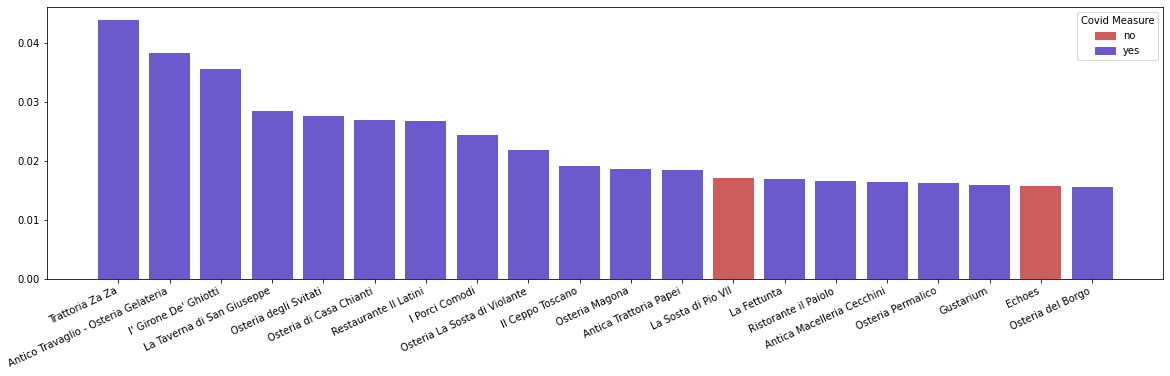

In [77]:
plotCentrality(df,centralities, k = 20)

In [78]:
centralitiesH = harmonic(G,routes,shortlen,normalizer)

100%|██████████████████████████████████████████████████████████████████████████████| 9107/9107 [02:07<00:00, 71.52it/s]


<ipython-input-70-b593ff505d6d>:16: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  mycolors = [['indianred','slateblue'][df.loc[r,'covidMeasure']] for r in restaurants]


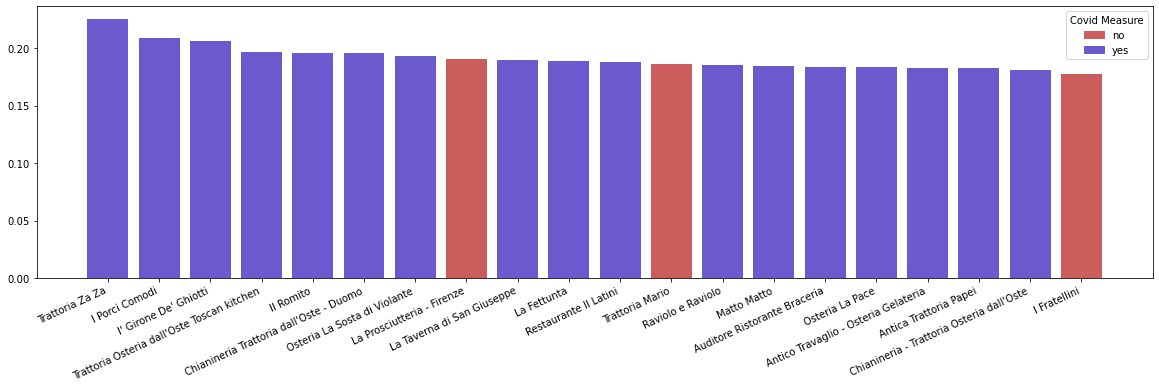

In [79]:
plotCentrality(df,centralitiesH, k = 20)

#### Geo

In [20]:
def geoDistance(df,u,v):
    
    xi, yi = df.loc[u,['longitude','latitude']]
    xj, yj = df.loc[v,['longitude','latitude']]
    return ((xj-xi)**2 + (yj-yi)**2)**0.5

In [21]:
def geolen(g,path):
    dist = 0 
    for i,v in enumerate(path):
        if v != path[-1]:
            dist += g.edges[(v[0],path[i+1][0],path[i+1][1])]['geodistance']
        
    return dist



def normalizer(g): 
    return 1

In [7]:

with open('../data/clean/allpathsGeo.PICKLE','rb') as f:
    georoutes = pickle.load(f)
    

In [9]:
geocentralities = betwenness(G,georoutes)

100%|██████████████████████████████████████████████████████████████████| 22333895/22333895 [02:04<00:00, 179838.59it/s]


<ipython-input-5-1b3c80d362ae>:14: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  mycolors = [['indianred','slateblue'][df.loc[r,'covidMeasure']] for r in restaurants]


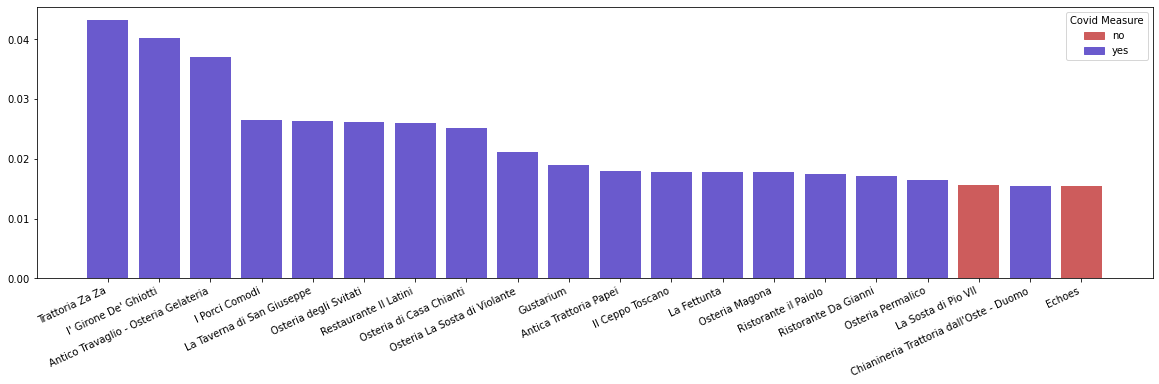

In [10]:
plotCentrality(df,geocentralities, k = 20)

In [22]:
geocentralitiesH = harmonic(G,routes,geolen,normalizer)

100%|██████████████████████████████████████████████████████████████████████████████| 9107/9107 [05:16<00:00, 28.76it/s]


In [43]:
norma = max([v for v in geocentralitiesH.values()])
centralities = {node:c/norma for node,c in  geocentralitiesH.items()}

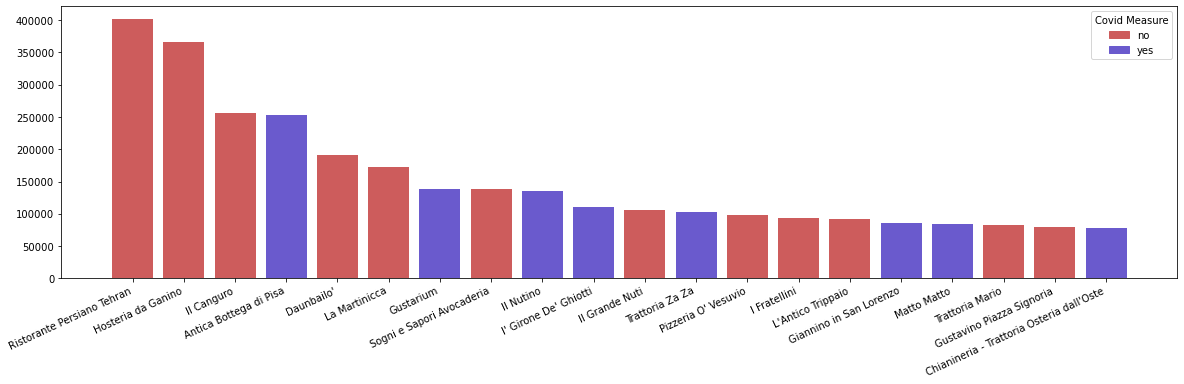

In [28]:
plotCentrality(df,geocentralitiesH, k = 20)

In [38]:
df.covidMeasure.value_counts()

False    15176
True       687
Name: covidMeasure, dtype: int64

#### DAYS

In [59]:
def daylen(G,path):
    endDate = path[-1][2]
    startDate = G.edges[(path[0][0],path[1][0],path[1][1])]['start']
    
    return endDate - startDate + 1


def normalizer(g):
    first = min([edge['start'] for edge in g.edges.values()])
    last = max([edge['end'] for edge in g.edges.values()])
    return last-first

In [55]:
normalizer(G)

431

In [13]:

with open('../data/clean/allpathsDays.PICKLE','rb') as f:
    dayroutes = pickle.load(f)

In [23]:
dayroutes[1972,11166]

[(1972, 0, 0),
 (2184, 0, 165),
 (2289, 0, 169),
 (11217, 0, 183),
 (11166, 0, 214)]

In [29]:
daylen(G,dayroutes[(1972,11166)])

49

In [14]:
daycentralities = betwenness(G,dayroutes)

100%|██████████████████████████████████████████████████████████████████| 21423384/21423384 [01:55<00:00, 185419.98it/s]


<ipython-input-70-b593ff505d6d>:16: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  mycolors = [['indianred','slateblue'][df.loc[r,'covidMeasure']] for r in restaurants]


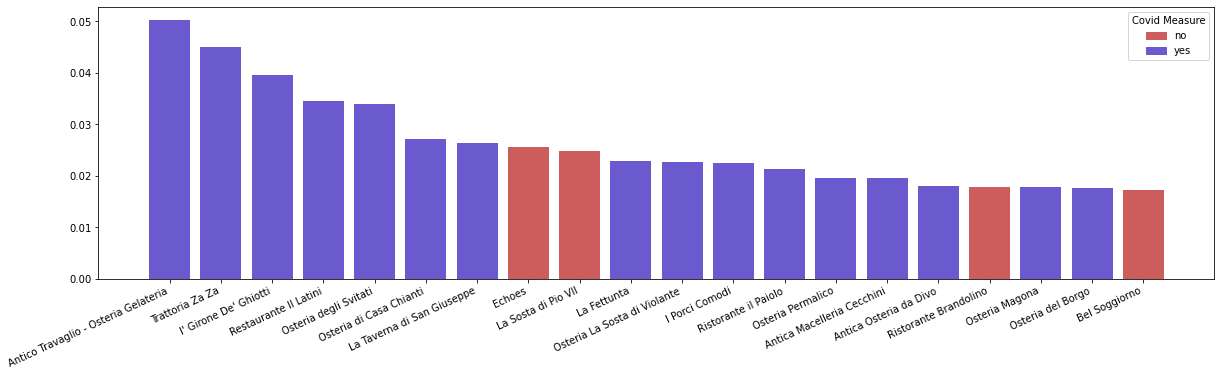

In [72]:
plotCentrality(df,daycentralities, k = 20)

In [60]:
daycentralitiesH = harmonic(G,dayroutes,daylen,normalizer = normalizer)

100%|██████████████████████████████████████████████████████████████████████████████| 9107/9107 [03:03<00:00, 49.73it/s]


In [32]:
plotCentrality(df,daycentralitiesH, k = 20)

NameError: name 'daycentralitiesH' is not defined

In [66]:
centralities = daycentralitiesH

In [67]:


restaurants = dict(sorted(centralities.items(), key=lambda item: item[1], reverse=True))

restaurantsNames = {df.loc[u,'name'] : c for u,c in restaurants.items()}

In [69]:
restaurantsNames

{'Trattoria Za Za': 0.5947068606297476,
 'La Taverna di San Giuseppe': 0.5759352152934685,
 'I Porci Comodi': 0.5724639114624297,
 'Antico Travaglio - Osteria Gelateria': 0.5307304698124317,
 'La Fortezza': 0.15902784564897612,
 'Osteria La Pace': 0.1807083612245608,
 'Osteria degli Svitati': 0.4993622134293107,
 'Sette di Vino': 0.48964455096453874,
 'Ristorante Da Gianni': 0.47673226499073845,
 'Enoteca Tognoni': 0.4754541217613817,
 'Il Ceppo Toscano': 0.4691953579814245,
 'La Buca di Enea': 0.45760352151708866,
 'Jhonny Paranza': 0.02733560833414964,
 'Le Viste Ristorante': 0.44795454289141146,
 "Porgi L'altra Pancia": 0.44605683192058637,
 'la Sosta del Priore': 0.4428855703604391,
 'L’Ostellino': 0.4400287774282548,
 'Antica Trattoria Papei': 0.43655454586336745,
 'Osteria Permalico': 0.4343019411756429,
 'Bel Soggiorno': 0.4333631822561458,
 'Osteria Magona': 0.43080798757296773,
 'La Lampara Capoliveri': 0.4295836159496333,
 "I' Girone De' Ghiotti": 0.42800872190246314,
 'Oster